# MTpy Example 11

## Modeling

Looking at the MT response is useful for understanding your data and generally what the data represents.  However, to get a full understanding of the subsurface we need to convert the measured MT response to an Earth response through forward modeling and inversion.  1D and 2D modeling can be done using Simpeg as presented by Seogi.  Here we will look at creating input files for ModEM.  We will create a model for just the Yellowstone area with the option of adding topography.


In [28]:
from pathlib import Path
import numpy as np
from mtpy import MTCollection
from mtpy.modeling import StructuredGrid3D

from mtpy.modeling.modem import (
 Covariance, ControlFwd, ControlInv
)

%matplotlib inline

### Open MTCollection

In the previous example we created a MTH5 file from existing Yellowstone data.  Let's load in the file and only pick out the area we'd like to invert, by applying a bounding box.

In [7]:
%%time
with MTCollection() as mc:
    mc.open_collection(Path().cwd().parent.parent.joinpath("data", "transfer_functions", "yellowstone_mt_collection.h5"))
    mc.apply_bbox(*[-111.4, -109.85, 44, 45.2])
    mt_data = mc.to_mt_data()

24:10:24T12:37:39 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing c:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\iris-mt-course-2022\data\transfer_functions\yellowstone_mt_collection.h5
CPU times: total: 17.5 s
Wall time: 19.5 s


## Plot Stations

Make sure we got everything we want.  

24:10:24T12:38:40 | WARNING | line:163 |mtpy.imaging.plot_stations | plot | Could not add base map because HTTPSConnectionPool(host='basemap.nationalmap.gov', port=443): Max retries exceeded with url: /arcgis/rest/services/USGSTopo/MapServer/tile/9/183/97 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1129)')))


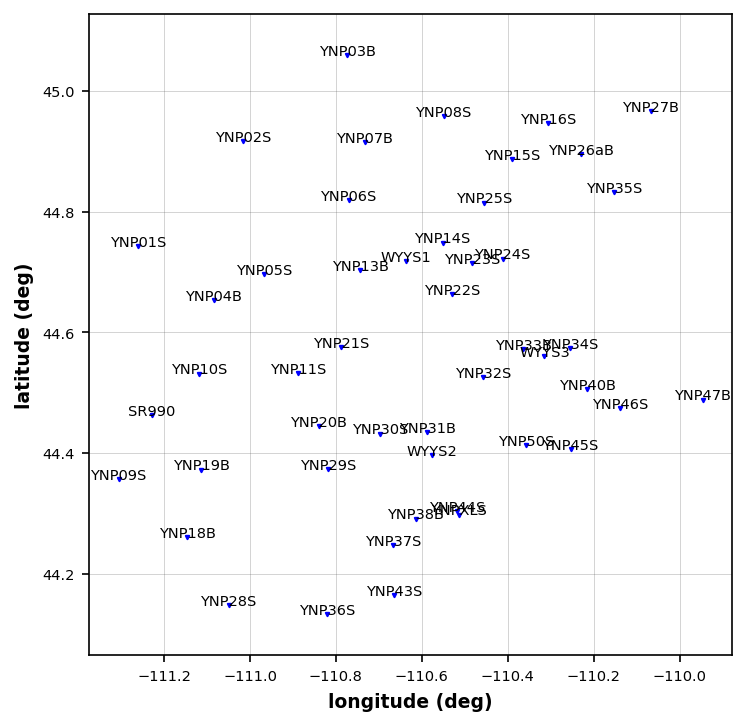

In [8]:
plot_stations = mt_data.plot_stations(fig_num=1)

## Check Stations

It looks like there are some stations close together, so we should decide which of them we should use for modeling.

- YNP44S, YNPXLS
- YNP33B, WYYS3, YNP34S


### Compare YNP44S and YNPXLS

We can plot these together and make an executive decision to keep one over the other.  From an eyeball test it appears YNPXLS is smoother in phase.  So lets keep YNPXLS and remove YNP44S

<Figure size 640x480 with 0 Axes>

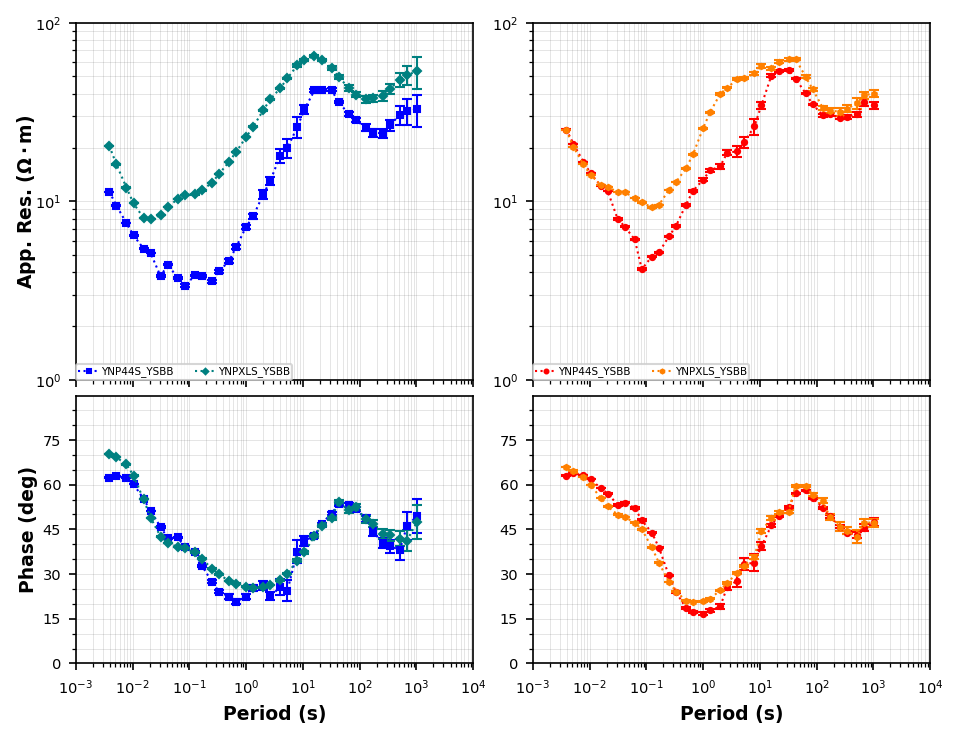

In [10]:
plot_compare = mt_data.plot_mt_response(station_key=["YSBB.YNP44S", "YSBB.YNPXLS"], plot_style="compare", fig_num=2)

### Compare YNP33B, WYYS3, YNP34S

It apears that YNP33B has a large static shift, and the phase is a little more noisy than YNP34.  Looks like WYYS3 is similar to YNP34S, so for this excersize we can remove WYYS3 as well because we will only use periods down to 1000 seconds.  

<Figure size 640x480 with 0 Axes>

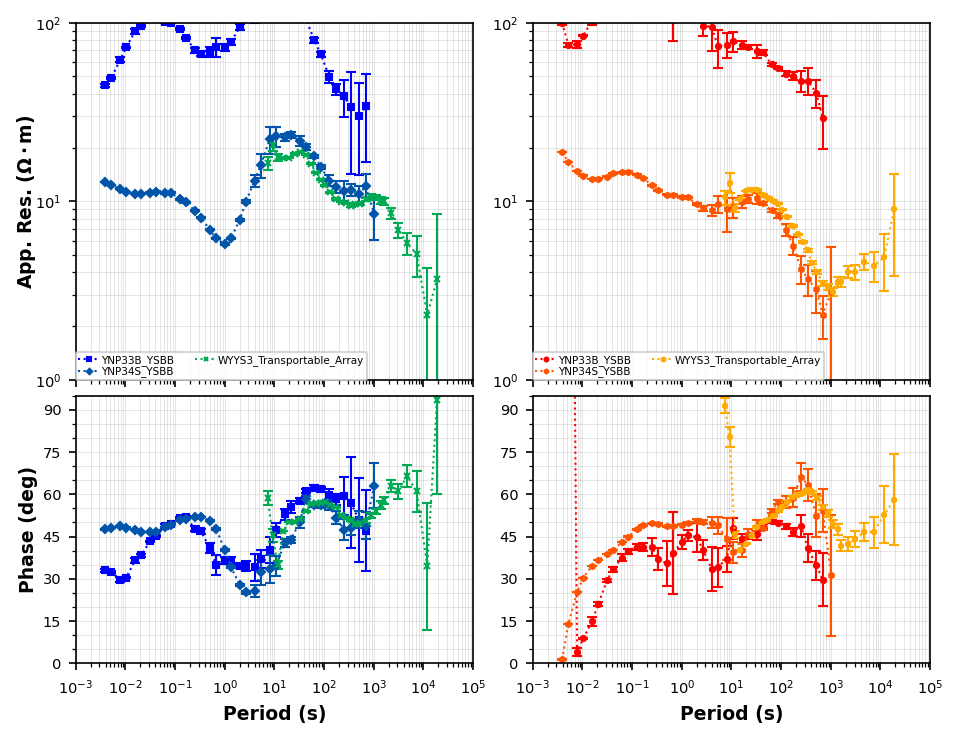

In [11]:
compare_plot_02 = mt_data.plot_mt_response(station_key=["YSBB.YNP33B", "YSBB.YNP34S", "Transportable_Array.WYYS3"], plot_style="compare", fig_num=4)

### Remove stations

Now that we have picked out some stations to remove let's get rid of them.

In [13]:
mt_data.remove_station("YNP44S", survey_id="YSBB")
mt_data.remove_station("YNP33B", survey_id="YSBB")
mt_data.remove_station("YWYYS3", survey_id="Transportabl_Array")

### Replot Stations

24:10:24T12:43:07 | WARNING | line:163 |mtpy.imaging.plot_stations | plot | Could not add base map because HTTPSConnectionPool(host='basemap.nationalmap.gov', port=443): Max retries exceeded with url: /arcgis/rest/services/USGSTopo/MapServer/tile/9/183/97 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1129)')))


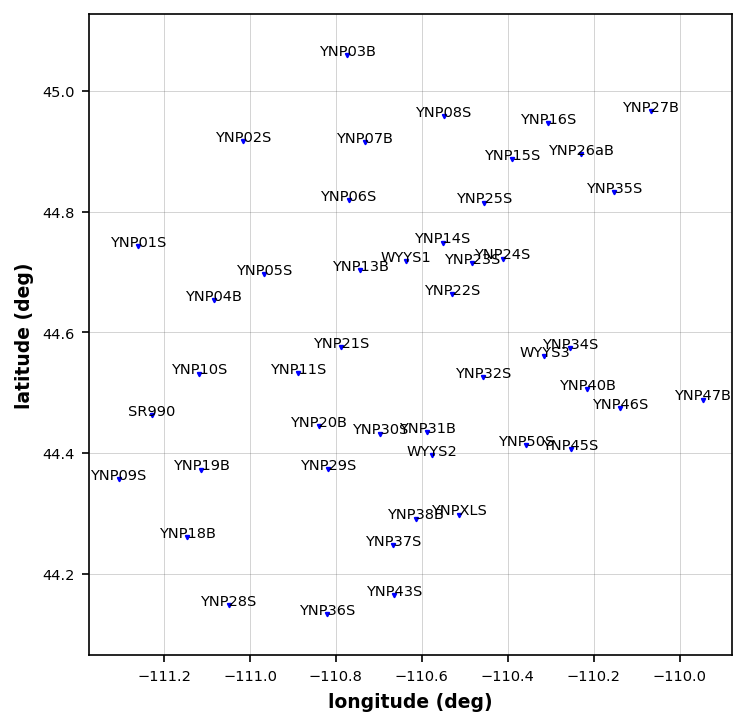

In [14]:
plot_stations_02 = mt_data.plot_stations(fig_num=5)

## Model Periods

Now that we have a decent station coverage we need to choose the periods to invert.  For 3D this is commonly decided by the computer architecture because the parallelization is often by period.  Here our compute power is limited to your desktop so lets use 10 periods over the period range (0.01, 1000).  We will use a spline interpolation for each component and both real and imaginary components.  

In [15]:
interp_periods = np.logspace(-2, 3, 10)

In [16]:
interp_mt_data = mt_data.interpolate(interp_periods, inplace=False)

Just check to make sure interpolation is accurate, lets plot some stations together.

<Figure size 640x480 with 0 Axes>

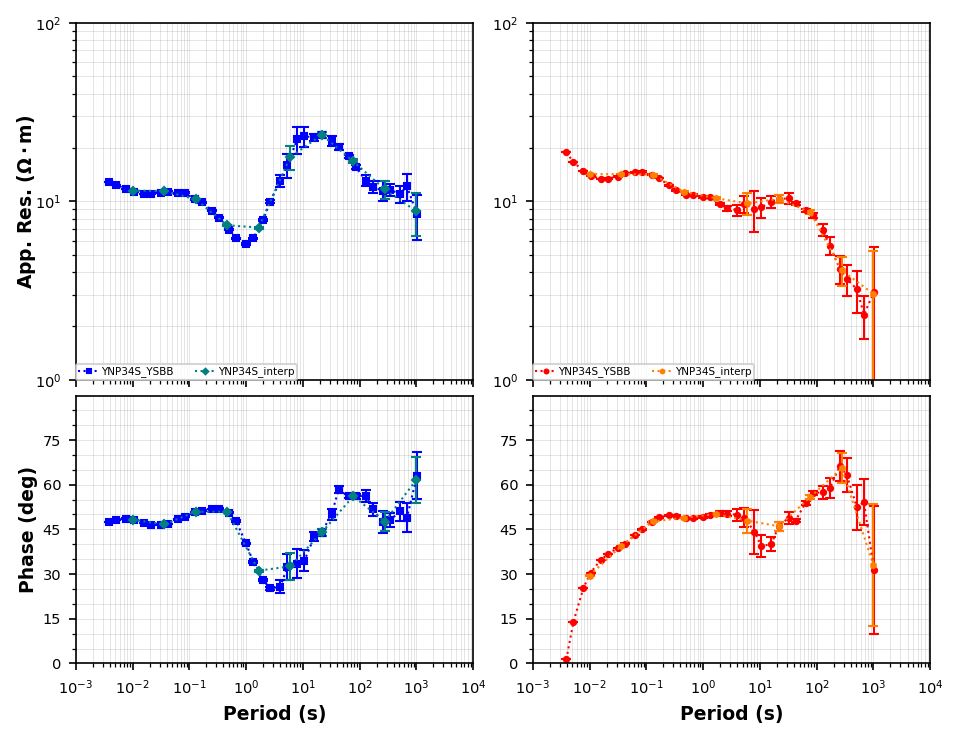

In [20]:
mt_01 = mt_data.get_subset(["YSBB.YNP34S"])
mt_02 = interp_mt_data.get_station(station_key="YSBB.YNP34S")
mt_02.survey = "interp"
mt_01.add_station(mt_02)

pmr = mt_01.plot_mt_response(station_key=list(mt_01.keys()), plot_style="compare", fig_num=6)

## Model Errors

Now that we have a decent station coverage we need to assigne model errors.  Typically we use some combination of the diagonal components and set an error floor of between 3 - 5%.  Below are the supported error types.

| Error Type          |    Dfinition                         |
|------------------------|---------------------------------------|
| egbert                |     error_value * sqrt(Zxy * Zyx) |
| geometric_mean        |    error_value * sqrt(Zxy * Zyx) |
| arithmetic_mean       |   error_value * (Zxy + Zyx) / 2 |
| mean_od               |     error_value * (Zxy + Zyx) / 2 |
| off_diagonals         |     zxx_err == zxy_err, zyx_err == zyy_err |
| median                |     error_value * median(z) |
| eigen                 |     error_value * mean(eigen(z)) |
| percent               |     error_value * z |
| absolute              |     error_value |

For this excersize we will use the defaults which are:

  - Impedance
     - `error_type = 'geometric_mean'`
     - `error_value = 0.05`
     - `floor = True`
  - Tipper
     - `error_type = 'absolute'`
     - `error_value = 0.02`
     - `floor = True`
     

In [21]:
interp_mt_data.compute_model_errors()

## Model Locations

ModEM Uses a relative grid for calculating the fields and is agnostic to geospatial postion.  Therefore, we need to place our stations on a relative grid where the center point is (0, 0).  We can then use these locations to make a model mesh. Somewhat counterintuitvely we need to provide a UTM coordinate system to estimate the easting and northing.  We will use WGS84 UTM Zone 12 --> EPSG = 32612

In [22]:
interp_mt_data.model_epsg = 32612

In [24]:
interp_mt_data.compute_relative_locations()

In [25]:
interp_mt_data.station_locations

,survey,station,latitude,longitude,elevation,datum_epsg,east,north,utm_epsg,model_east,model_north,model_elevation,profile_offset
0,Transportable_Array,WYYS1,44.718500,-110.638000,2423.450,4326,528670.497892,4.951744e+06,32612,-1032.463332,13631.692270,2423.450,0.0
1,Transportable_Array,WYYS2,44.396350,-110.577000,2399.188,4326,533687.076364,4.915983e+06,32612,3984.115140,-22129.033907,2399.188,0.0
2,Transportable_Array,WYYS3,44.560700,-110.315000,2387.725,4326,554399.450607,4.934380e+06,32612,24696.489383,-3732.328080,2387.725,0.0
3,YSBB,YNP01S,44.742639,-111.260583,2017.630,4326,479370.312946,4.954395e+06,32612,-50332.648278,16282.383927,2017.630,0.0
4,YSBB,YNP02S,44.916667,-111.015472,2246.020,4326,498778.785861,4.973693e+06,32612,-30924.175363,35581.178751,2246.020,0.0
5,YSBB,YNP03B,45.058972,-110.773333,1587.590,4326,517846.465206,4.989526e+06,32612,-11856.496017,51414.359258,1587.590,0.0
6,YSBB,YNP04B,44.653278,-111.084722,2037.310,4326,493282.443984,4.944439e+06,32612,-36420.517239,6326.492173,2037.310,0.0
7,YSBB,YNP05S,44.696556,-110.967917,2079.350,4326,502541.968724,4.949243e+06,32612,-27160.992500,11130.839917,2079.350,0.0
8,YSBB,YNP06S,44.819056,-110.770444,2293.950,4326,518149.344183,4.962876e+06,32612,-11553.617041,24763.584594,2293.950,0.0
9,YSBB,YNP07B,44.915333,-110.732750,2217.660,4326,521094.386236,4.973580e+06,32612,-8608.574988,35467.683765,2217.660,0.0


## Write Data File

The data is ready to go, lets write it to a file.

In [26]:
interp_mt_data.to_modem(
    Path().cwd().parent.parent.joinpath("data", "modeling", "ynp_z05_t02.dat"),
    topography=False
)

24:10:24T12:50:40 | WARNING | line:553 |mtpy.modeling.modem.data | _check_for_too_small_errors | Found errors with values less than 0.02 in z_xy 1 times. Setting error as z_xy x 0.05.
24:10:24T12:50:40 | WARNING | line:553 |mtpy.modeling.modem.data | _check_for_too_small_errors | Found errors with values less than 0.02 in z_yx 3 times. Setting error as z_yx x 0.05.
24:10:24T12:50:40 | INFO | line:680 |mtpy.modeling.modem.data | write_data_file | Wrote ModEM data file to c:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\iris-mt-course-2022\data\modeling\ynp_z05_t02.dat


ModEM Data Object:
	Number of impedance stations: 46
	Number of tipper stations: 46
	Number of phase tensor stations: 46
	Number of periods:  10
	Period range (s):  
		Min: 0.01
		Max: 1000
	Rotation angle:     0
	Data center:        
		Latitude:   44.5957 deg 	Northing: 4938112.1287 m
		Longitude: -110.6258 deg 	Easting: 529702.9612 m
		Datum epsg: 4326			UTM epsg:   32612
		Elevation:  0.0 m
	Impedance data:     True
	Tipper data:        True
	Inversion Mode:   Full_Impedance, Full_Vertical_Components

## Model Grid

ModEM uses the finite difference which computes the fields on the faces of an unstructured rectangular grid.  

### Horizontal Cells

In the horizontal direction cell sizes are often uniform in width within the area of interest.  Commonly you would like at least 1 free cell between stations and usually more to allow the inversion to model smoothly varying resistivity structures.  So if your station spaceing is 2 km, your model cell sizes could be between 200 - 1000 meters.  

### Vertical Cells
In the vertical direction the height should increase with depth to account for MT being a diffusive method.  The rate of increase would ideally be a geometric factor of about 1.2, but computationally this can be expensive, therefore it is a good idea to change that parameter to grid that can provide resolution down to a desired depth and be relatively efficient.  The first layer should be about 1/5th the skin depth of your shortest period.  If you shortest period is 0.01 seconds and an estimate of the subsurface apparent resistivity is 100, then your skin depth is 500 * sqrt(0.01 * 100) = 500 m, and your top layer could be 100 m.  

### Padding Cells
Because MT is a volumetric measurement and measurement periods are long, the model needs to be sufficiently large enough to minimize edge effects.  The extents of the model should be about 2-5 times the maximum skin depth away from the station area.  If your longest period is 1000 seconds, the approximate skin depth for an apparent resistivity of 100 would be 500 * sqrt(1000 * 100) ~ 150 km.  Therefore your model should extend at leat 150 km from the edge of the station area in all directions.  So if you station area is 25 km v 25 km your model extents should be 325 km x 325 km.  Now this isn't always practical and the skin depths are just estimates, so playing around with padding cells can be a useful excersize.  These padding cells can be large and you may only need a few.

### Making the Mesh
To make the mesh we need the station locations and the center point. We will set some parameters that are coarse so that this can run on a desktop.

In [40]:
model_mesh = StructuredGrid3D(interp_mt_data.station_locations, interp_mt_data.center_point)
model_mesh.station_locations.model_elevation = 0

24:10:24T12:57:22 | WARNING | line:1747 |mtpy.modeling.structured_mesh_3d | _validate_extent | Provided or default ew_ext not sufficient to fit stations + padding, updating extent
24:10:24T12:57:22 | WARNING | line:1753 |mtpy.modeling.structured_mesh_3d | _validate_extent | Provided or default ns_ext not sufficient to fit stations + padding, updating extent
Structured3DMesh Model Object:
--------------------
	Number of stations = 46
	Mesh Parameter: 
		cell_size_east:    3500
		cell_size_north:   3500
		pad_east:          7
		pad_north:         7
		pad_num:           3
		z1_layer:          50
		z_target_depth:    30000
		n_layers:          40
		n_air_layers:      0
		res_initial_value: 100.0
	Dimensions: 
		e-w: 56
		n-s: 53
		z:   41 (without 7 air layers)
	Extensions: 
		e-w:  291500.0 (m)
		n-s:  265000.0 (m)
		0-z:  52380.0 (m)
--------------------
24:10:24T12:57:22 | WARNING | line:49 |mtpy.modeling.plots.plot_mesh | _plot_topography | Cannot find topography information, skipping


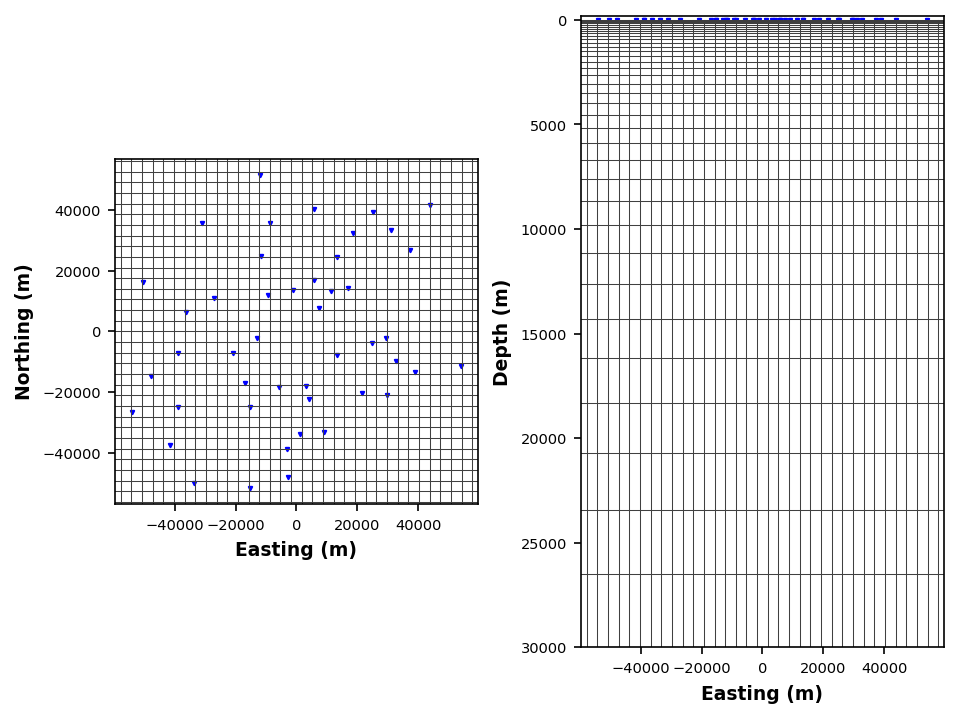

Plotting PlotMesh

In [41]:
model_mesh.cell_size_east = 3500
model_mesh.cell_size_north = 3500
model_mesh.z1_layer = 50
model_mesh.z_target_depth = 30000
model_mesh.n_layers = 40
model_mesh.make_mesh()
model_mesh.plot_mesh(fig_num=8, plot_station_id=False)

## Estimating Starting Half Space

The starting half-space is important because it provides the inversion with a decent starting point. Therefore, in practice it is a good idea to estimate what a good starting resistivity is.  Here we will take the average and median of all apparent resistivity values across the survey.  From this 100 is a good choice, which is a common starting resistivity.

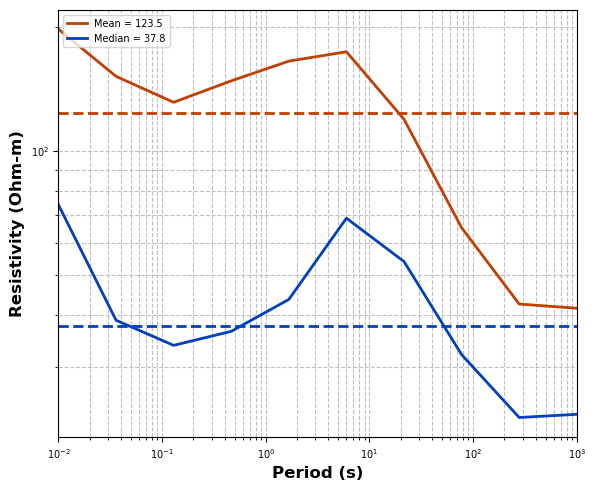

In [42]:
interp_mt_data.estimate_starting_rho()

In [43]:
model_mesh.res_initial_value = 100

## Write Model File

We have a decent mesh, lets write to a file

In [44]:
model_mesh.to_modem(
    model_fn=Path().cwd().parent.parent.joinpath("data", "modeling", "ynp_sm02.rho"), 
)

24:10:24T12:57:35 | INFO | line:873 |mtpy.modeling.structured_mesh_3d | to_modem | Wrote file to: c:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\iris-mt-course-2022\data\modeling\ynp_sm02.rho


## Covariance 

ModEM uses a regularization parameter called covariance, which controls how smooth the inversion should be, with higher values being more smooth and lower values being coarser.  You can apply the covariance multiple times if you like, so sometimes it is adventageous to use a smaller covariance value but apply it multiple times.  The covariance in ModEM sort of describes the length of smoothing, in that it uses the a certain number of cells depending on the value.  At the padding cells this can blowup and provide unrealistic values and are usually ignored in plotting.  Varying the covariance is an excersize in itself.  For this we will apply a common covariance of 0.3 in all directions just once.

In [45]:
covariance = Covariance(grid_dimensions=model_mesh.res_model.shape)
covariance.write_covariance_file(
    Path().cwd().parent.parent.joinpath("data", "modeling", "ynp_covariance.cov")
)

24:10:24T12:57:38 | INFO | line:235 |mtpy.modeling.modem.convariance | write_covariance_file | Wrote covariance file to c:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\iris-mt-course-2022\data\modeling\ynp_covariance.cov


## Control Files

How ModEM computes the forward model and how the inversion runs can be controlled through control files.  These are often kept to the default values, you may change the starting lambda depending on your modeling method.

In [46]:
control_fwd = ControlFwd()
control_fwd.write_control_file(
    Path().cwd().parent.parent.joinpath("data", "modeling", "control.fwd")
)

Wrote ModEM control file to c:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\iris-mt-course-2022\data\modeling\control.fwd


In [47]:
control_inv = ControlInv()
control_inv.write_control_file(
    Path().cwd().parent.parent.joinpath("data", "modeling", "control.inv")
)

Wrote ModEM control file to c:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\iris-mt-course-2022\data\modeling\control.inv


### Adding Topography

For topographically extreme areas it can be useful to include topography into the model.  We just need to provide an ascii elevation file formatted in the form ArcGIS.  More formats will be supported in the future, but these are relatively common for coarse topography.  You can download DEMs from [https://www.ncei.noaa.gov/maps/grid-extract/](https://www.ncei.noaa.gov/maps/grid-extract/).  One is provided for this data set.  

**Note**: If you are including topography in the model, you need to center the stations to the model cell, otherwise weird things can happen.  

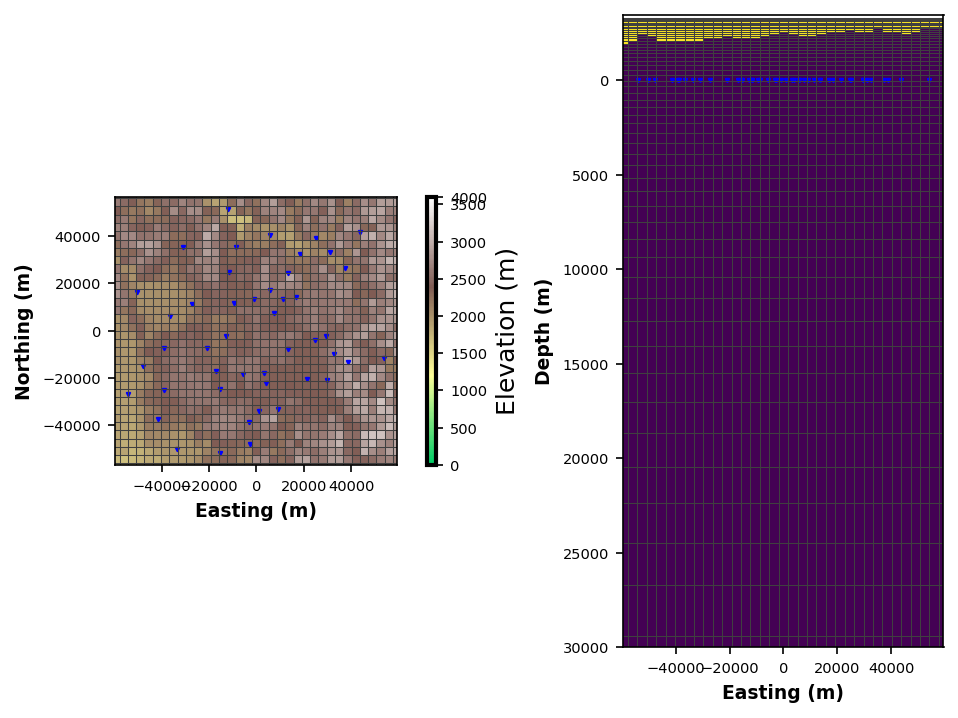

24:10:24T12:58:12 | INFO | line:873 |mtpy.modeling.structured_mesh_3d | to_modem | Wrote file to: c:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\iris-mt-course-2022\data\modeling\ynp_sm02_topo.rho


In [49]:
model_mesh.n_air_layers = 15
model_mesh.add_topography_to_model(
    Path().cwd().parent.parent.joinpath("data", "modeling", "yellowstone.asc"),
    airlayer_type="log_down"
)
model_mesh.plot_mesh(fig_num=10)
model_mesh.to_modem(
    model_fn=Path().cwd().parent.parent.joinpath("data", "modeling", "ynp_sm02_topo.rho"), 
)

### Write Topography Covariance

Now that topography is added into the model we want to make sure the air cells remain locked.

In [51]:
topo_covariance = Covariance(grid_dimensions=model_mesh.res_model.shape)
topo_covariance.write_covariance_file(
    Path().cwd().parent.parent.joinpath("data", "modeling", "ynp_covariance_topo.cov"),
    res_model=model_mesh.res_model,
)

24:10:24T12:59:25 | INFO | line:235 |mtpy.modeling.modem.convariance | write_covariance_file | Wrote covariance file to c:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\iris-mt-course-2022\data\modeling\ynp_covariance_topo.cov


## Centering Station and Projecting on to Topography

We need to now center the stations to their cell and project the station to the topgraphic surface.

In [52]:
interp_mt_data.center_stations(model_mesh)
interp_mt_data.project_stations_on_topography(model_mesh)
interp_mt_data.station_locations

,survey,station,latitude,longitude,elevation,datum_epsg,east,north,utm_epsg,model_east,model_north,model_elevation,profile_offset
0,Transportable_Array,WYYS1,44.718500,-110.638000,2423.450,4326,528670.497892,4.951744e+06,32612,0.0,12250.0,-2440.999,0.0
1,Transportable_Array,WYYS2,44.396350,-110.577000,2399.188,4326,533687.076364,4.915983e+06,32612,3500.0,-22750.0,-2325.999,0.0
2,Transportable_Array,WYYS3,44.560700,-110.315000,2387.725,4326,554399.450607,4.934380e+06,32612,24500.0,-5250.0,-2325.999,0.0
3,YSBB,YNP01S,44.742639,-111.260583,2017.630,4326,479370.312946,4.954395e+06,32612,-49000.0,15750.0,-1921.999,0.0
4,YSBB,YNP02S,44.916667,-111.015472,2246.020,4326,498778.785861,4.973693e+06,32612,-31500.0,36750.0,-2325.999,0.0
5,YSBB,YNP03B,45.058972,-110.773333,1587.590,4326,517846.465206,4.989526e+06,32612,-10500.0,50750.0,-1921.999,0.0
6,YSBB,YNP04B,44.653278,-111.084722,2037.310,4326,493282.443984,4.944439e+06,32612,-35000.0,5250.0,-2066.999,0.0
7,YSBB,YNP05S,44.696556,-110.967917,2079.350,4326,502541.968724,4.949243e+06,32612,-28000.0,12250.0,-2066.999,0.0
8,YSBB,YNP06S,44.819056,-110.770444,2293.950,4326,518149.344183,4.962876e+06,32612,-10500.0,26250.0,-2325.999,0.0
9,YSBB,YNP07B,44.915333,-110.732750,2217.660,4326,521094.386236,4.973580e+06,32612,-7000.0,36750.0,-2325.999,0.0


In [53]:
interp_mt_data.to_modem(
    Path().cwd().parent.parent.joinpath("data", "modeling", "ynp_z05_t02_topo.dat"),
    topography=True
)

24:10:24T12:59:47 | WARNING | line:553 |mtpy.modeling.modem.data | _check_for_too_small_errors | Found errors with values less than 0.02 in z_xy 1 times. Setting error as z_xy x 0.05.
24:10:24T12:59:47 | WARNING | line:553 |mtpy.modeling.modem.data | _check_for_too_small_errors | Found errors with values less than 0.02 in z_yx 3 times. Setting error as z_yx x 0.05.
24:10:24T12:59:47 | INFO | line:680 |mtpy.modeling.modem.data | write_data_file | Wrote ModEM data file to c:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\iris-mt-course-2022\data\modeling\ynp_z05_t02_topo.dat


ModEM Data Object:
	Number of impedance stations: 46
	Number of tipper stations: 46
	Number of phase tensor stations: 46
	Number of periods:  10
	Period range (s):  
		Min: 0.01
		Max: 1000
	Rotation angle:     0
	Data center:        
		Latitude:   44.5957 deg 	Northing: 4938112.1287 m
		Longitude: -110.6258 deg 	Easting: 529702.9612 m
		Datum epsg: 4326			UTM epsg:   32612
		Elevation:  0.0 m
	Impedance data:     True
	Tipper data:        True
	Inversion Mode:   Full_Impedance, Full_Vertical_Components